# Troubleshooting getCl integration

In [17]:
import crosspower as cp
import FisherCl as fcl # branch quickCl
#import FisherCl2 as fcl # branch master
#import camb

# set plotting to be in the notebook instead of its own qt window
%matplotlib inline

In [20]:
# Create a Fisher Matrix object
import time
reload(fcl.cp)
reload(fcl)
z0 = 0.3
zmax = 4
nBins = 4
lmax = 1000
AccuracyBoost = 3
doNorm = True #False

starttime = time.time()
Fobj = fcl.FisherMatrix(lmax=lmax,z0=z0,zmax=zmax,nBins=nBins,doNorm=doNorm)
#Fobj = fcl.FisherMatrix(lmax=lmax,z0=z0,zmax=zmax,nBins=nBins,AccuracyBoost=AccuracyBoost,doNorm=doNorm)
endtime = time.time()

print 'time elapsed: ', endtime-starttime, ' seconds'
print 'time elapsed: ', (endtime-starttime)/60., ' minutes'
print 'time elapsed: ', (endtime-starttime)/3600., ' hours'

print 'binAs: ',Fobj.binAs
print 'binBs: ',Fobj.binBs

creating matter power spectrum object...
zs.size:  998
creating more matter power objects...
creating matter power spectra for  ombh2  derivative...
zs.size:  998
zs.size:  998
creating matter power spectra for  omch2  derivative...
zs.size:  998
zs.size:  998
creating matter power spectra for  cosmomc_theta  derivative...
zs.size:  998
zs.size:  998
creating matter power spectra for  As  derivative...
zs.size:  998
zs.size:  998
creating matter power spectra for  ns  derivative...
zs.size:  998
zs.size:  998
creating matter power spectra for  tau  derivative...
zs.size:  998
zs.size:  998
creating matter power spectra for  mnu  derivative...
zs.size:  998
zs.size:  998
fiducial bs:  [ 1.50047442  2.13440099  2.9413001   3.76877611]
fiducial As:  [ 1.00203366  1.00130307  1.00116382  1.001109  ]
starting cross power with entire kappa... 
starting angular cross power spectrum  0 ,  0 ... 
window  1 : kappa  0
window  2 : kappa  0
window  1 : kappa  0
window  2 : kappa  0
window  1 : kap

starting angular cross power spectrum  2 ,  2 ... 
window  1 : kappa  3
window  2 : kappa  3
window  1 : kappa  3
window  2 : galaxies  3
window  1 : galaxies  3
window  2 : galaxies  3
starting angular cross power spectrum  3 ,  3 ... 
window  1 : kappa  4
window  2 : kappa  4
window  1 : kappa  4
window  2 : galaxies  4
window  1 : galaxies  4
window  2 : galaxies  4
building covariance matrix... 
starting covariance set  1  of  5 ... 
starting covariance set  2  of  5 ... 
starting covariance set  3  of  5 ... 
starting covariance set  4  of  5 ... 
starting covariance set  5  of  5 ... 
inverting covariance matrix... 
starting creation of C_l derivatives... 
starting derivative set  1  of  5 ... 
starting derivative set  2  of  5 ... 
starting derivative set  3  of  5 ... 
starting derivative set  4  of  5 ... 
starting derivative set  5  of  5 ... 
building Fisher matrix from components...
invCov.shape:  (15, 15, 999) , dClVecs.shape:  (15, 11, 999)
starting bin set  1  of  11
sta

In [21]:
# save it

import pickle



filehandler = open('Fisher_4_4B.obj','w') # accuracyBoost=3,doNorm=False,lmax=1000; from FisherCl branch quickCl



# ditch the myPk part since pickle can't handle classes within a class
myPkTemp = Fobj.myPk
Fobj.myPk = 0
pickle.dump(Fobj,filehandler)
filehandler.close()

#pickle.dump(myPkTemp,filehandler2)
# put it back
Fobj.myPk = myPkTemp
print 'done'


done


In [22]:
# load saved Fobj
# get lensing and galaxy Fisher matrix to add
"""
import FisherCl2 as fcl
import pickle
filehandler2 = open('Fisher_4_4g_Dal.obj', 'r') 
Fobj = pickle.load(filehandler2) 
lmax = 1000

print Fobj.obsList
print Fobj.paramList
"""

"\nimport FisherCl2 as fcl\nimport pickle\nfilehandler2 = open('Fisher_4_4g_Dal.obj', 'r') \nFobj = pickle.load(filehandler2) \nlmax = 1000\n\nprint Fobj.obsList\nprint Fobj.paramList\n"

In [23]:
# display the sigmas
# this does not take lmin= 50 into account.
paramList = Fobj.paramList
sigmas = Fobj.getSigmas()
for i, param in enumerate(paramList):
    print param, ': ',sigmas[i]

ombh2 :  0.00110447013087
omch2 :  0.00327732690458
cosmomc_theta :  3.76509508728e-05
As :  5.14311200954e-11
ns :  0.0093563779653
tau :  4.46116142801
mnu :  0.0320611925603
bin1 :  0.0458412262176
bin2 :  0.0532923828884
bin3 :  0.106051708859
bin4 :  0.161897573343


In [24]:
# remake the kappa-g Fij with lmin=50 to match the other Fij
# make comparison against version with higher lmin
# copy some code from FisherMatrix.__init__

def makeFisher(Fobj,lmin,lmax):
    """ code copied from FisherMatrix.__init__
        Inputs:
            Fobj:
            lmin: minimum ell to make Fij
    """
    #Build Fisher matrix
    #multply vectorT,invcov,vector and add up
    print 'building Fisher matrix from components...'
    print 'invCov.shape: ',Fobj.invCov.shape,', dClVecs.shape: ',Fobj.dClVecs.shape
    nParams = Fobj.nParams
    #lmax = 2000 #Fobj.lmax
    Fij = np.zeros((nParams,nParams)) # indices match those in paramList
    for i in range(nParams):
      print 'starting bin set ',i+1,' of ',nParams
      dClVec_i = Fobj.dClVecs[:,i,:] # shape (nCls,nElls)
      for j in range(nParams):
        dClVec_j = Fobj.dClVecs[:,j,:] # shape (nCls,nElls)
        # ugh.  don't like nested loops in Python... but easier to program...
        for ell in range(lmin-2,lmax-1): #-2 to match the indices
          myCov = Fobj.invCov[:,:,ell]
          fij = np.dot(dClVec_i[:,ell],np.dot(myCov,dClVec_j[:,ell]))
          
          Fij[i,j] += fij
    
    print 'creation of Fisher Matrix complete!\n'
    return Fij

In [25]:
lmin=50
Fij2 = makeFisher(Fobj,lmin,lmax)
sigmas2 = np.sqrt(np.diag(np.linalg.inv(Fij2)))

building Fisher matrix from components...
invCov.shape:  (15, 15, 999) , dClVecs.shape:  (15, 11, 999)
starting bin set  1  of  11
starting bin set  2  of  11
starting bin set  3  of  11
starting bin set  4  of  11
starting bin set  5  of  11
starting bin set  6  of  11
starting bin set  7  of  11
starting bin set  8  of  11
starting bin set  9  of  11
starting bin set  10  of  11
starting bin set  11  of  11
creation of Fisher Matrix complete!



In [26]:
# add prior on Tau
tauNum = 5
priorTauSigma = 0.02
tauPrior = 1/priorTauSigma**2
print Fij2[tauNum,tauNum]
Fij2[tauNum,tauNum] = Fij2[tauNum,tauNum] + tauPrior 
print Fij2[tauNum,tauNum]

# remake sigmas2 with this
sigmas2 = np.sqrt(np.diag(np.linalg.inv(Fij2)))

3.48169231738
2503.48169232


In [27]:
for i,p in enumerate(paramList):
    print p, sigmas2[i]

ombh2 0.000906518358402
omch2 0.00241052345109
cosmomc_theta 2.80220948959e-05
As 3.97014285651e-11
ns 0.00538700782852
tau 0.0199998055347
mnu 0.0300670617918
bin1 0.035292926951
bin2 0.038432668371
bin3 0.0970789987134
bin4 0.121725967313


In [28]:
# check covariance matrix
# sum over all ell
print Fobj.covar.shape
print np.sum(Fobj.covar,2)

(15, 15, 999)
[[  1.29380686e-13   6.54719843e-06   1.07200288e-06   2.29915128e-07
    7.47722591e-08   3.96587693e+02   5.07721110e+01   9.89145490e+00
    3.07268531e+00   9.19384672e+00   1.99784026e+00   6.51372301e-01
    4.55602654e-01   1.51972619e-01   5.12879336e-02]
 [  6.54719843e-06   5.96109428e+02   2.53860555e+01   4.94572745e+00
    1.53634265e+00   4.91745803e+10   3.05228648e+09   5.88063211e+08
    1.81739098e+08   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.07200288e-06   2.53860555e+01   3.31037437e+01   9.98920128e-01
    3.25686151e-01   0.00000000e+00   1.36642688e+09   0.00000000e+00
    0.00000000e+00   4.87873008e+08   5.26818520e+07   1.71269507e+07
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.29915128e-07   4.94572745e+00   9.98920128e-01   3.39021766e+00
    7.59863096e-02   0.00000000e+00   0.00000000e+00   1.36791328e+08
    0.00000000e+00   0.00000000e+00   2.74688404e+07  

In [29]:
# zeroes in the right places.  ok.

In [30]:
# check the power spectra for blips or worse
print Fobj.crossCls.shape
print Fobj.crossClsPlus.shape
print Fobj.crossClsMinus.shape
# example: (3,3,999) means 999 symmetric 3x3 matrices, one at each ell
nMaps = Fobj.nBins+1
ells = Fobj.ells
print 'nMaps = ',nMaps
nCosParams = Fobj.nParams - Fobj.nBins
print 'nCosParams = ',nCosParams
paramList = Fobj.paramList
print 'paramList = ',paramList

(5, 5, 999)
(5, 5, 7, 999)
(5, 5, 7, 999)
nMaps =  5
nCosParams =  7
paramList =  ['ombh2', 'omch2', 'cosmomc_theta', 'As', 'ns', 'tau', 'mnu', 'bin1', 'bin2', 'bin3', 'bin4']


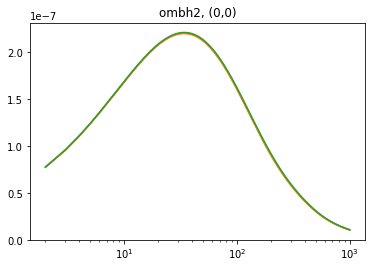

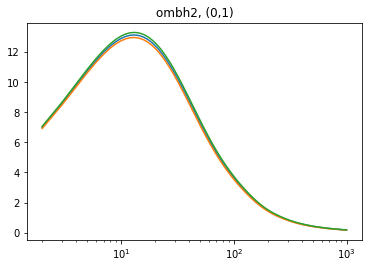

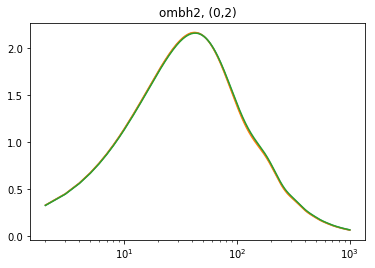

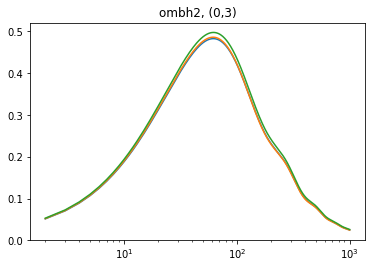

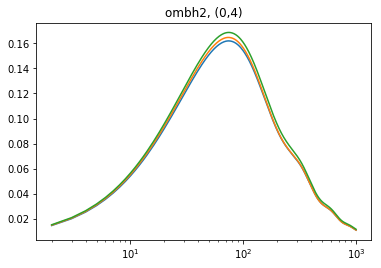

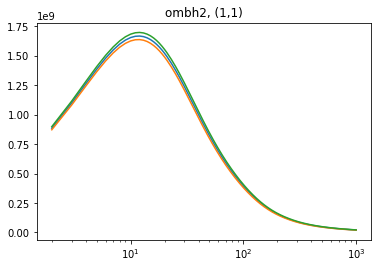

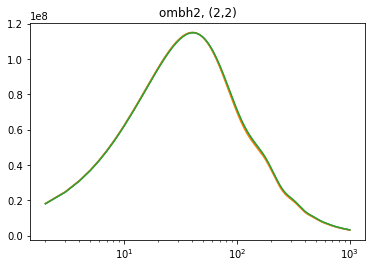

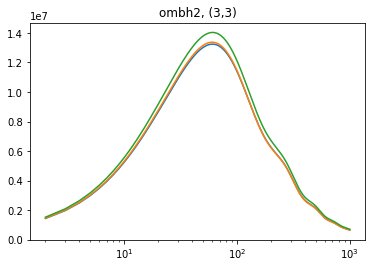

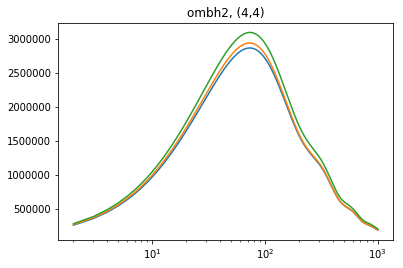

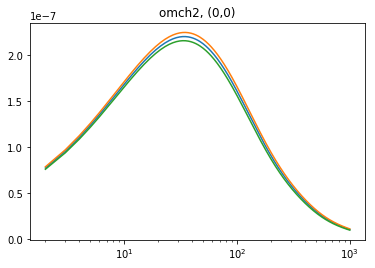

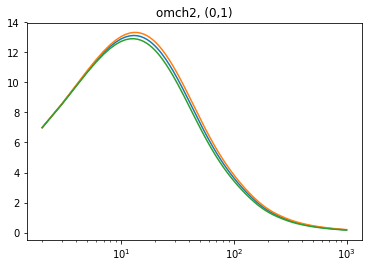

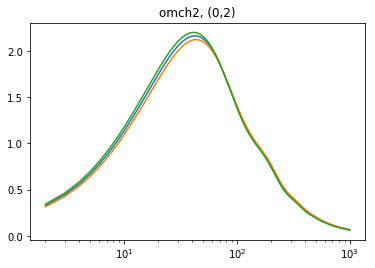

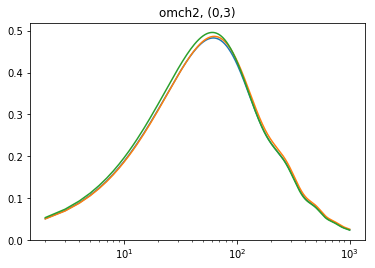

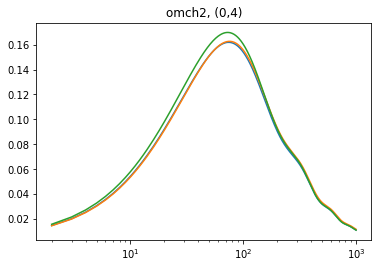

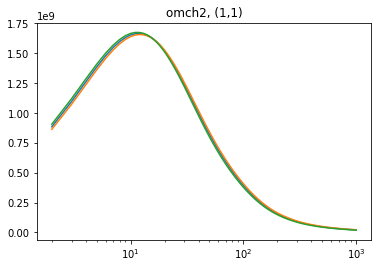

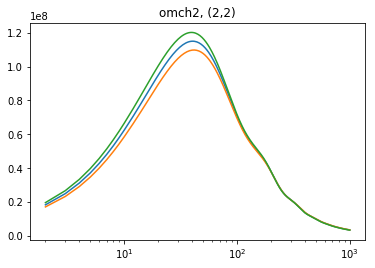

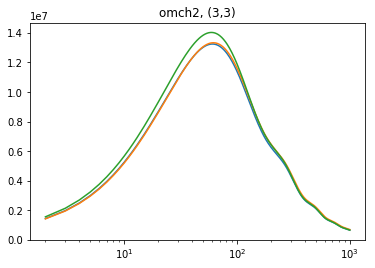

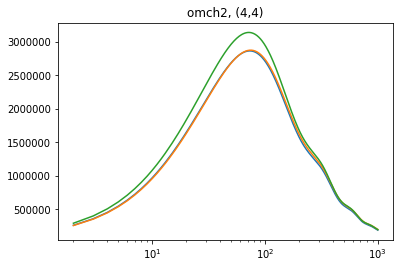

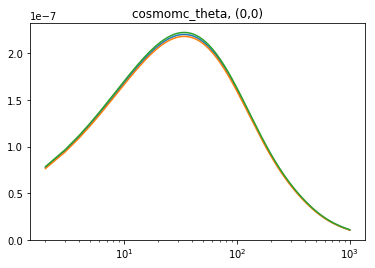

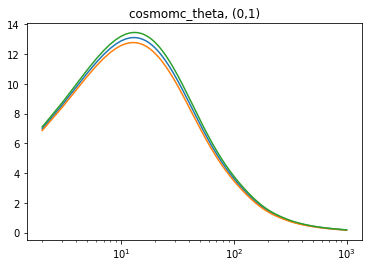

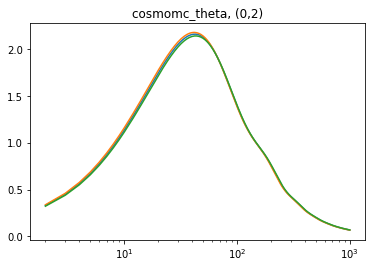

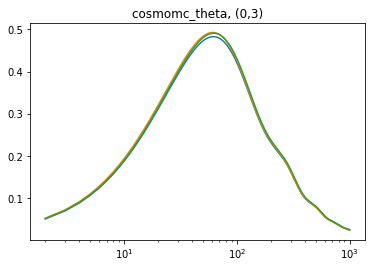

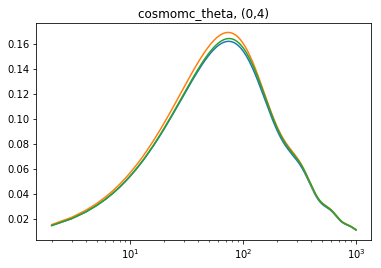

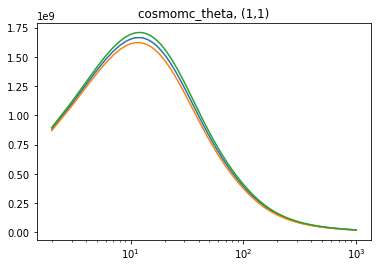

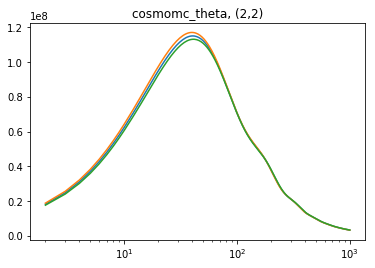

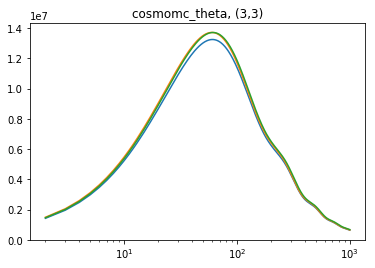

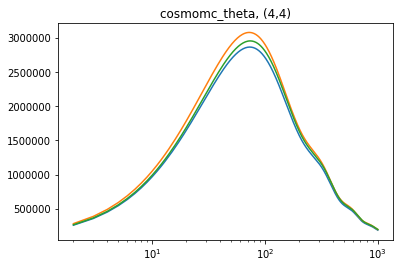

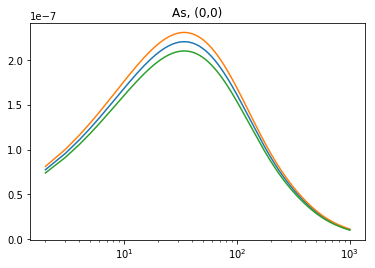

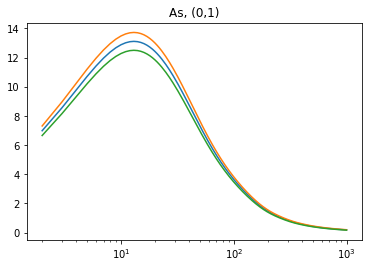

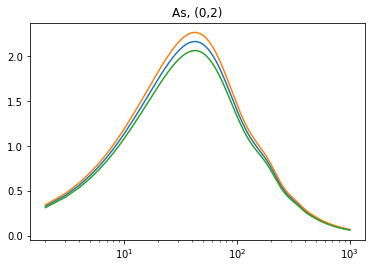

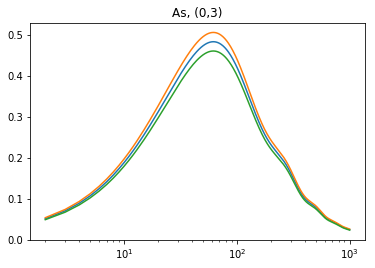

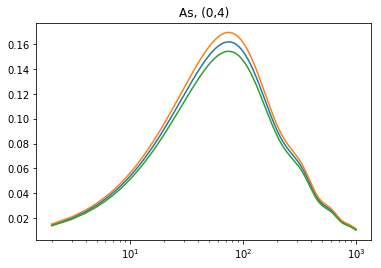

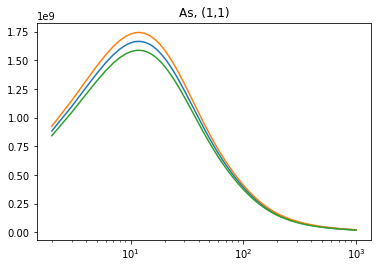

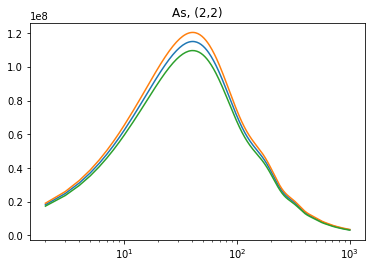

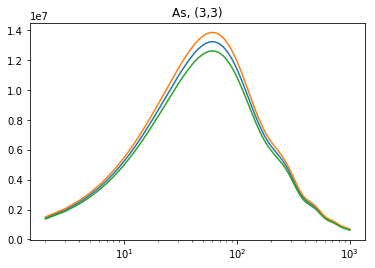

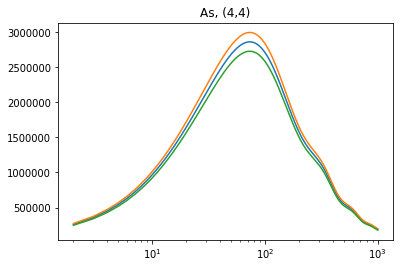

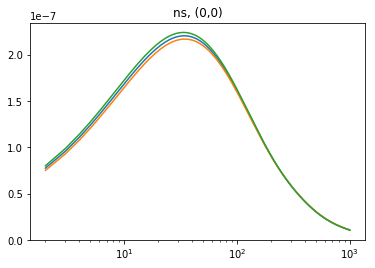

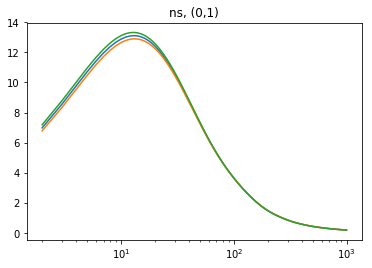

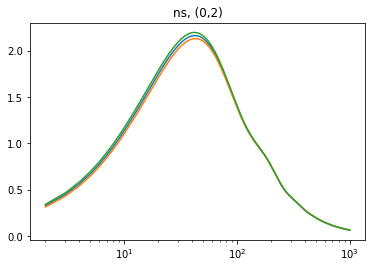

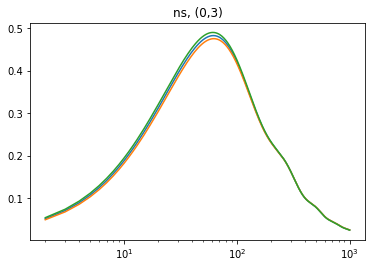

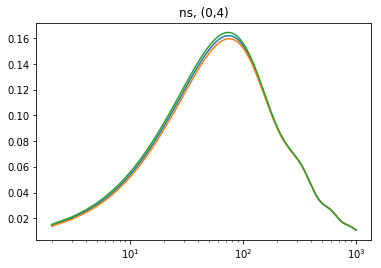

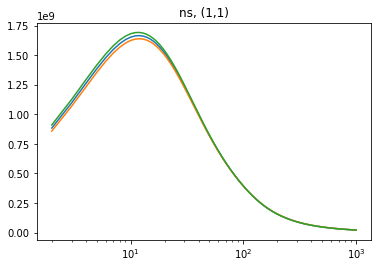

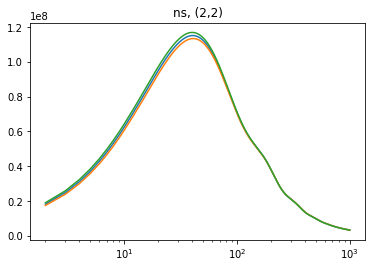

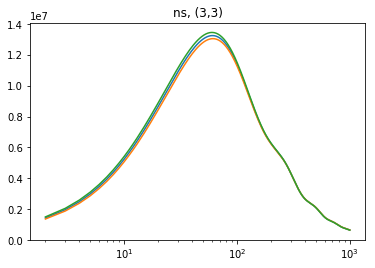

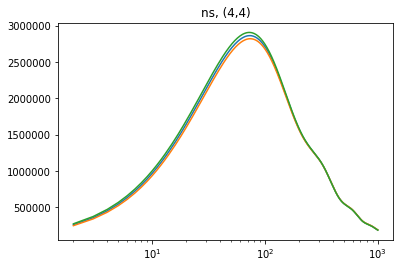

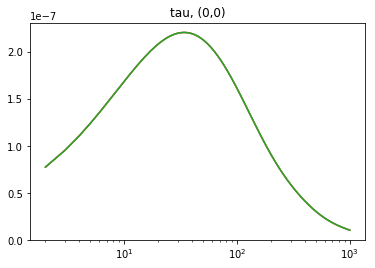

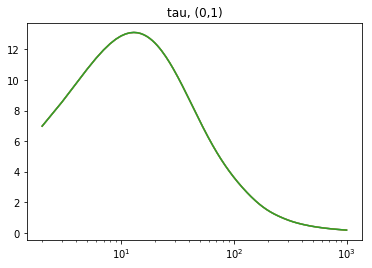

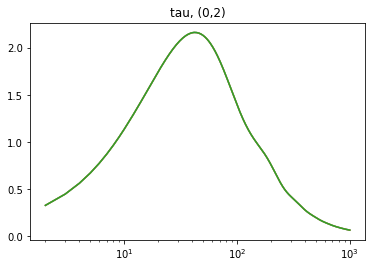

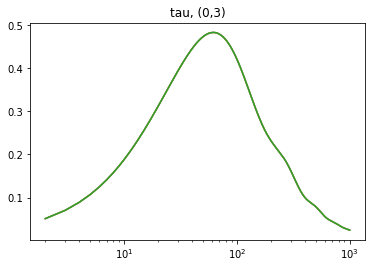

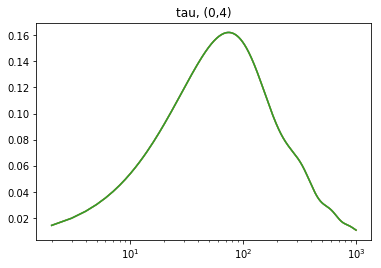

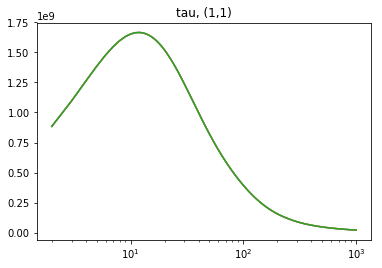

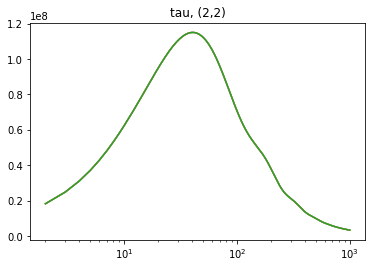

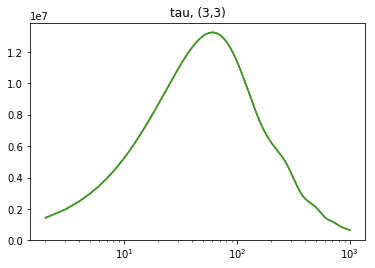

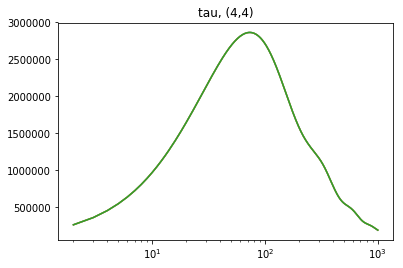

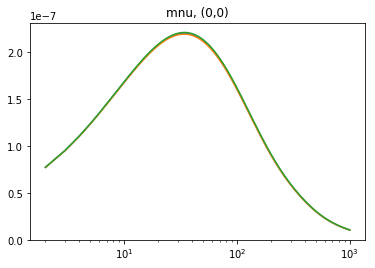

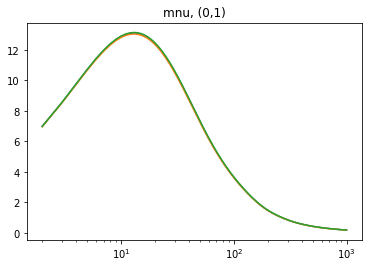

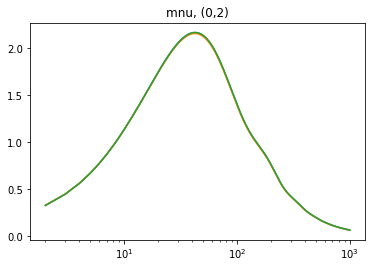

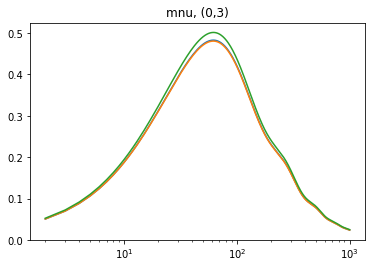

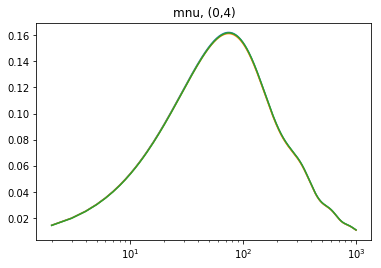

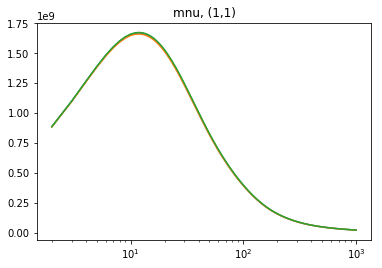

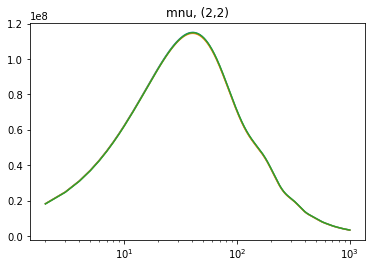

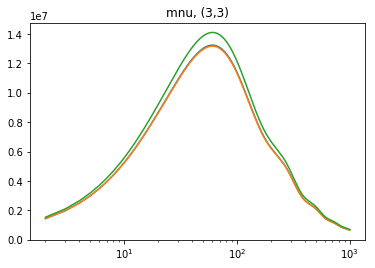

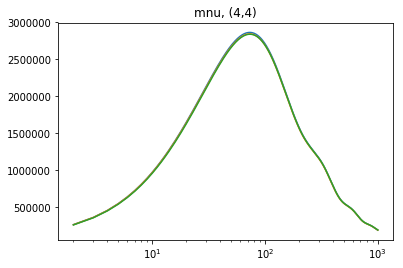

In [31]:
%matplotlib inline
for param in range(nCosParams):        
    for obs1 in range(nMaps):
        for obs2 in range(obs1,nMaps):
            if obs1 == 0 or obs1 == obs2:
                plt.semilogx(ells,Fobj.crossCls[obs1,obs2])
                plt.semilogx(ells,Fobj.crossClsPlus[obs1,obs2,param])
                plt.semilogx(ells,Fobj.crossClsMinus[obs1,obs2,param])
                plt.title(paramList[param]+', ('+str(obs1)+','+str(obs2)+')')
                plt.show()

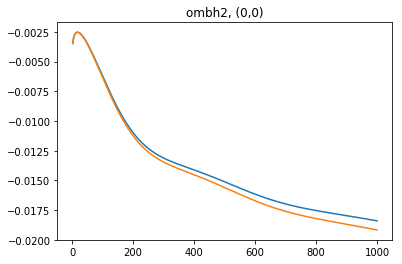

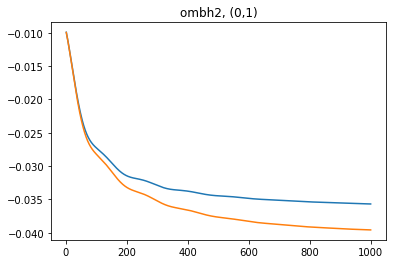

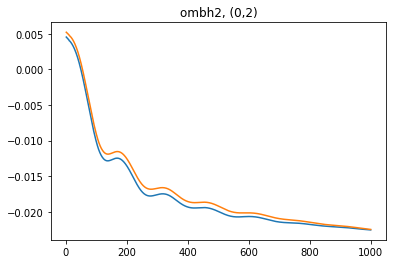

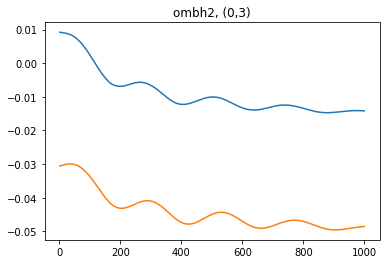

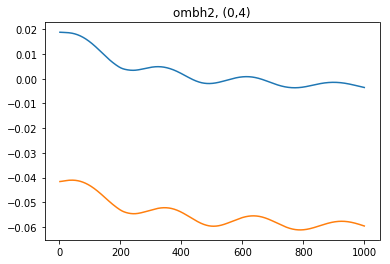

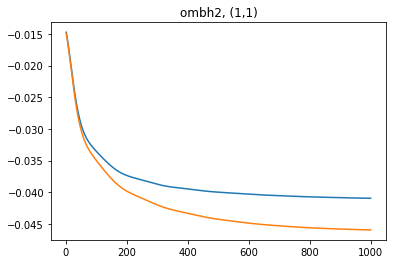

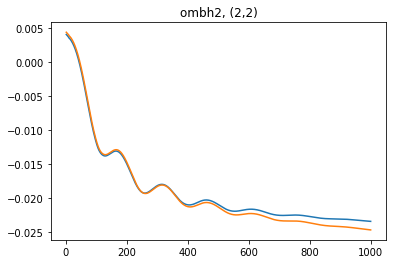

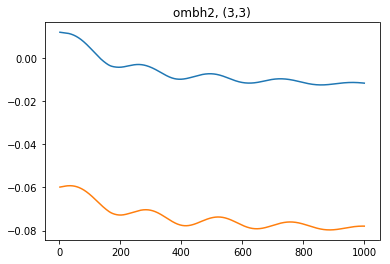

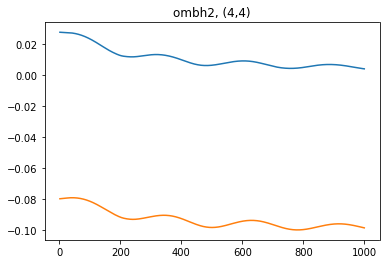

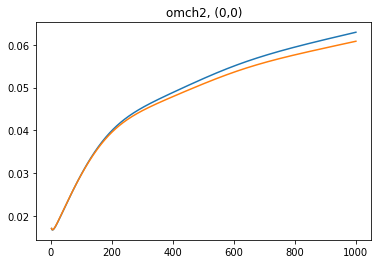

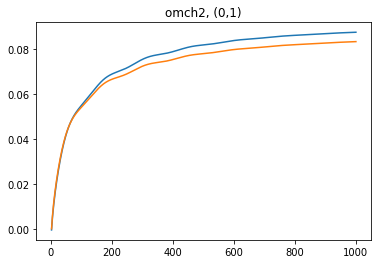

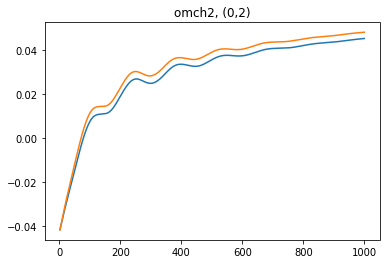

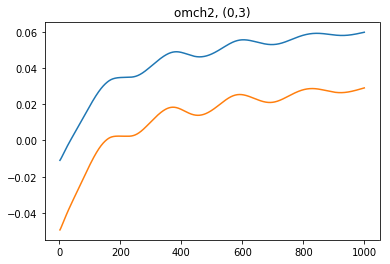

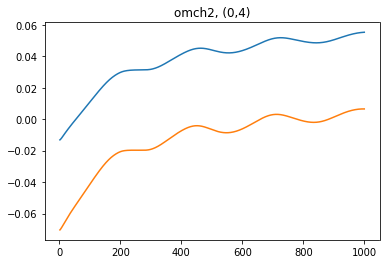

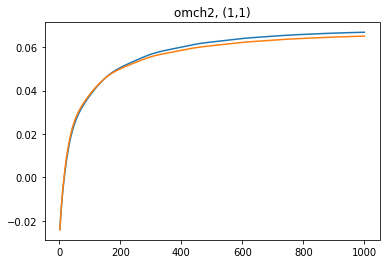

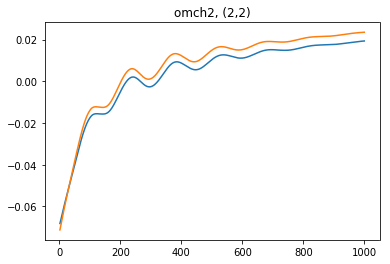

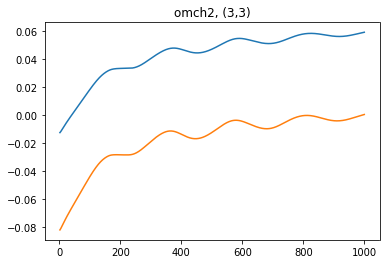

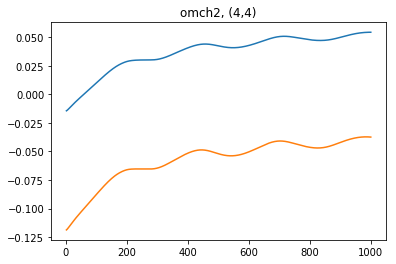

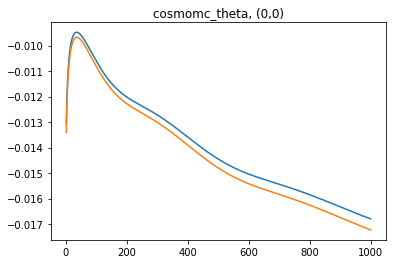

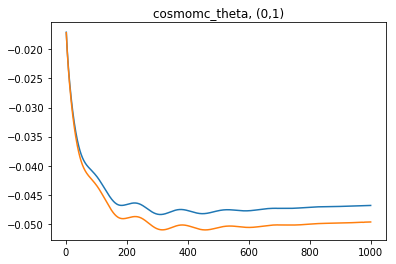

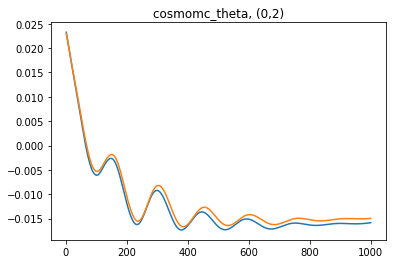

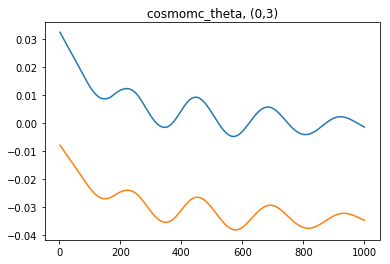

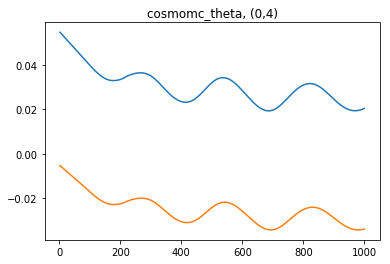

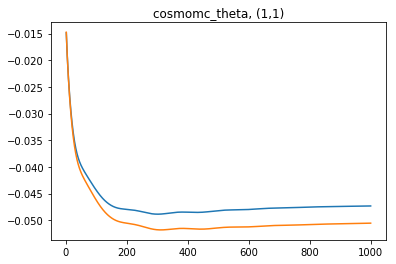

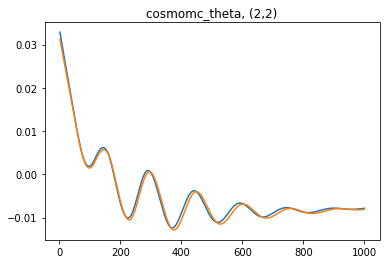

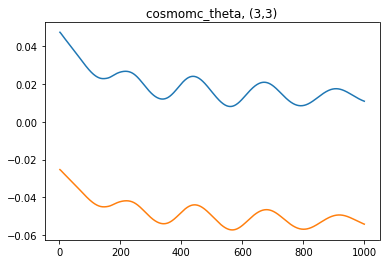

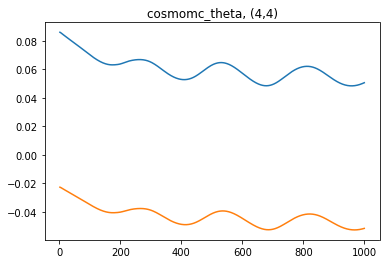

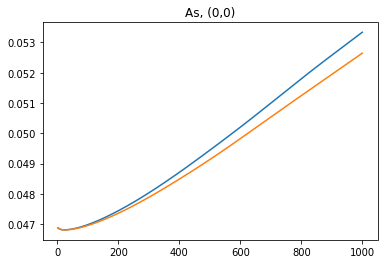

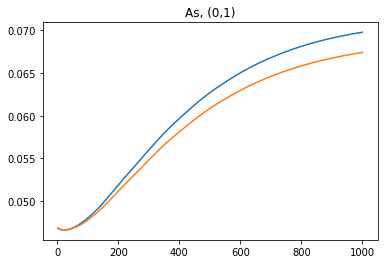

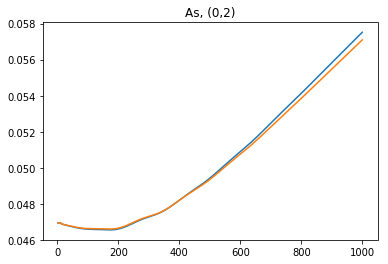

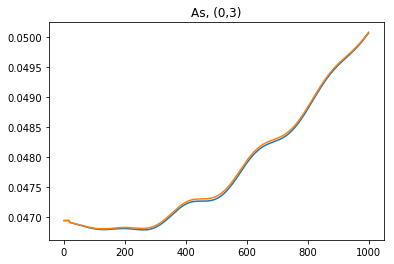

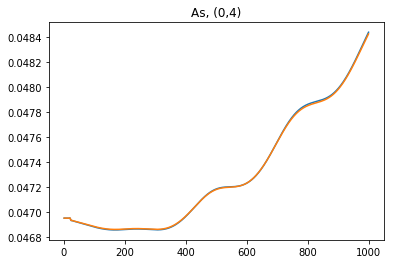

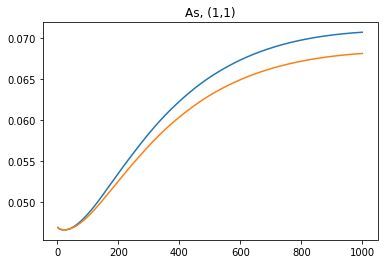

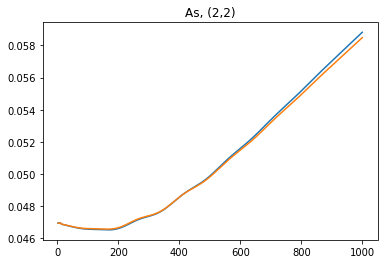

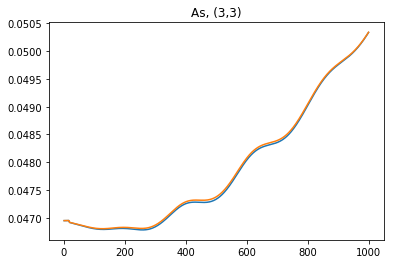

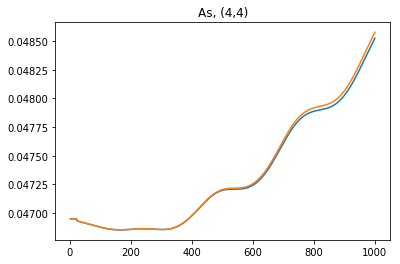

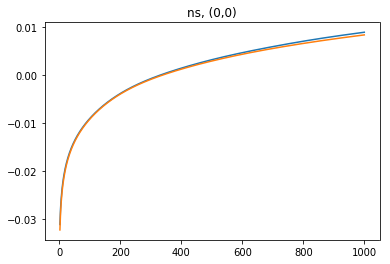

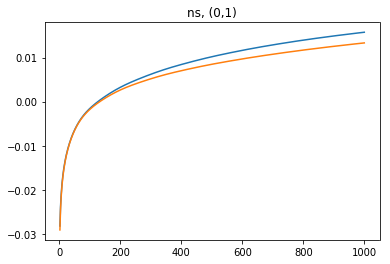

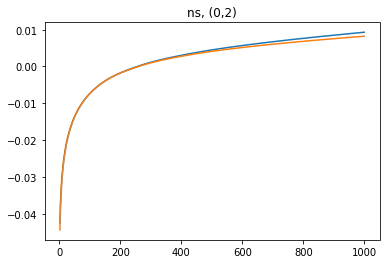

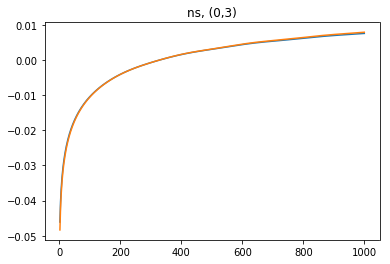

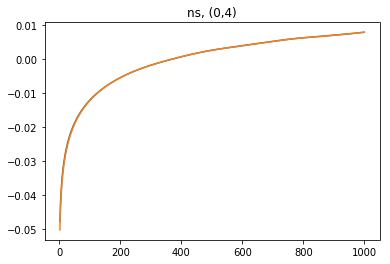

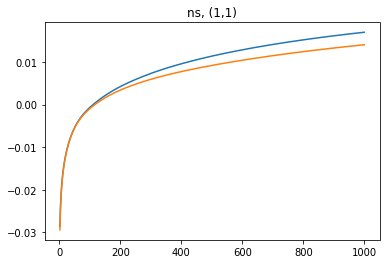

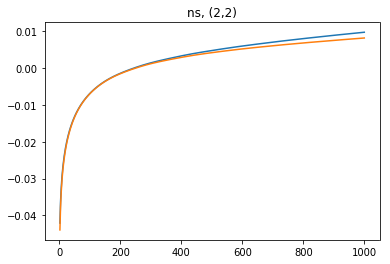

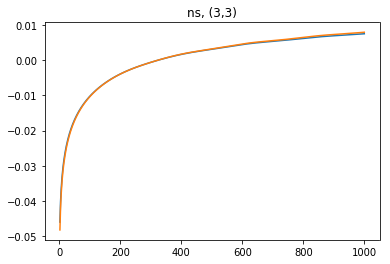

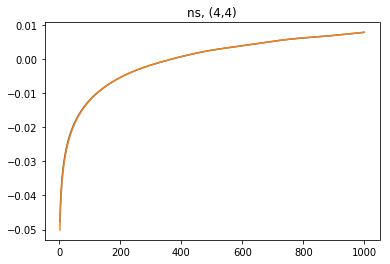

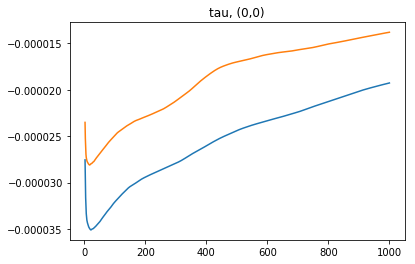

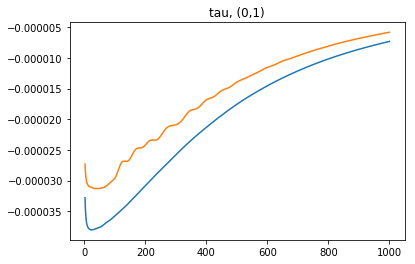

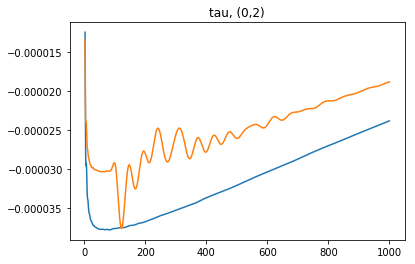

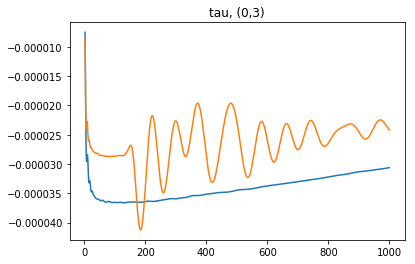

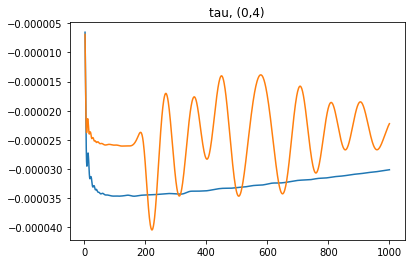

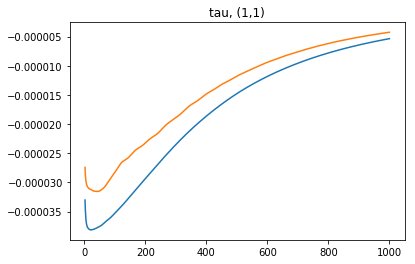

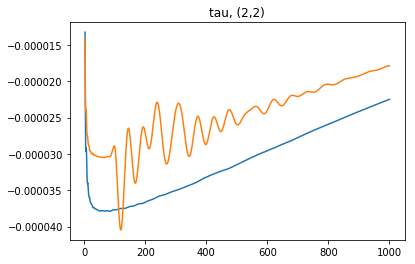

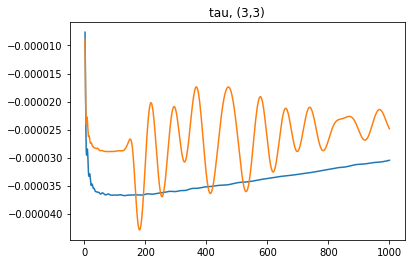

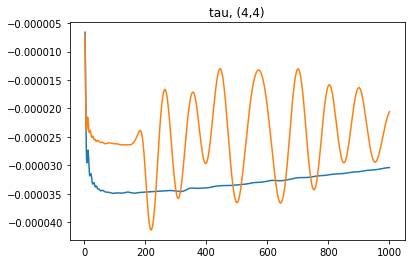

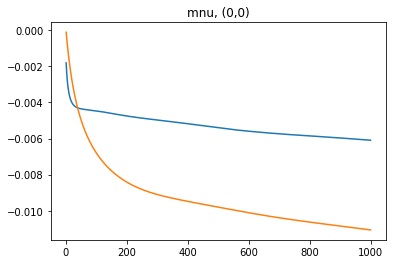

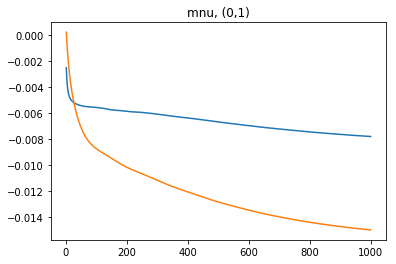

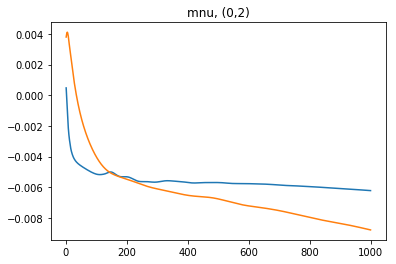

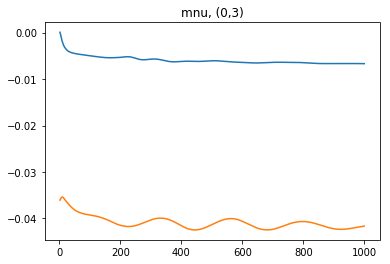

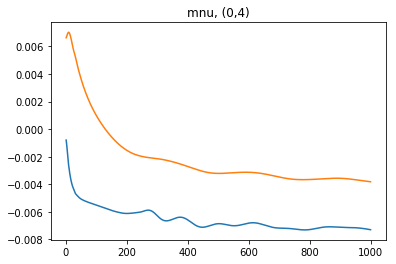

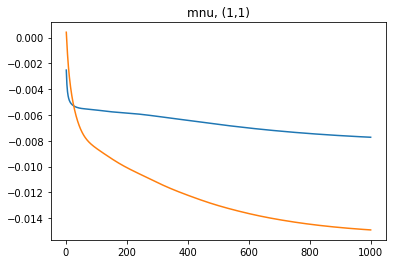

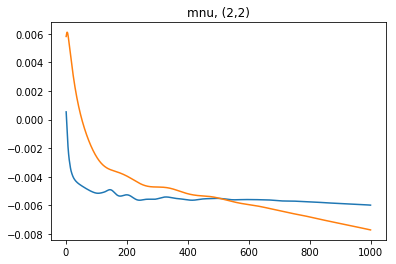

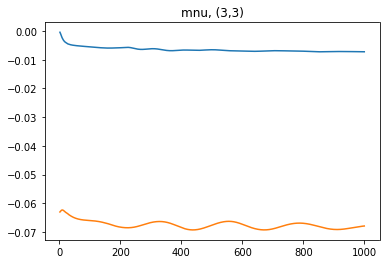

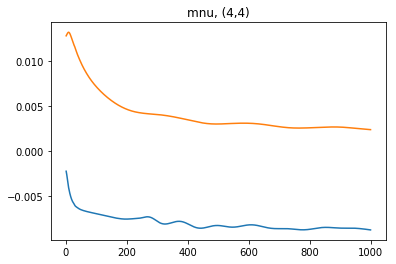

In [32]:
%matplotlib inline
for param in range(nCosParams):        
    for obs1 in range(nMaps):
        for obs2 in range(obs1,nMaps):
            if obs1 == 0 or obs1 == obs2:
                nominal = Fobj.crossCls[obs1,obs2]
                plus = Fobj.crossClsPlus[obs1,obs2,param]
                minus = Fobj.crossClsMinus[obs1,obs2,param]
                plt.plot(ells,(plus-nominal)/nominal)
                plt.plot(ells,(nominal-minus)/nominal)
                plt.title(paramList[param]+', ('+str(obs1)+','+str(obs2)+')')
                plt.show()

# Match Byeonghee's plots

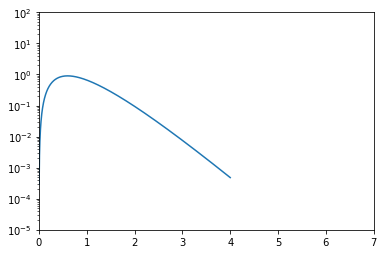

In [33]:
# dn/dz
zs = np.linspace(0,4,1000)
z0 = 0.3
dndzs = cp.modelDNDZ(zs,z0)
plt.semilogy(zs,dndzs)
plt.ylim([1e-5,1e2])
plt.xlim([0,7])
plt.show()

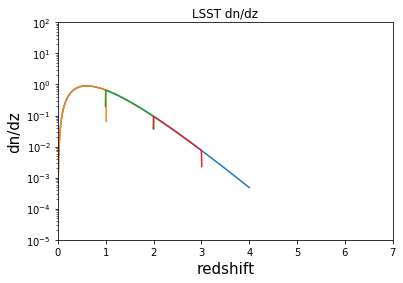

In [34]:
# now in bins
#dndzFuncs = []
for binNum in range(4):
    dndzF = cp.getDNDZinterp(binNum=binNum,zmin=0,zmax=4,nBins=4,z0=z0)
    plt.semilogy(zs,dndzF(zs))
plt.ylim([1e-5,1e2])
plt.xlim([0,7])
plt.xlabel('redshift',fontsize=15)
plt.ylabel('dn/dz',fontsize=15)
plt.title('LSST dn/dz')
plt.show()

(5, 5, 999)
5


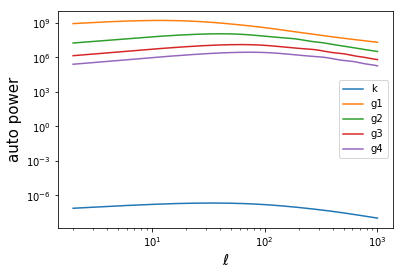

In [36]:
# plot auto power spectra
print Fobj.crossCls.shape
# auto power are on diagonal
print nMaps
labels = ['k','g1','g2','g3','g4']
for mapNum in range(nMaps):
    plt.loglog(ells,Fobj.crossCls[mapNum,mapNum],label=labels[mapNum])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel('auto power',fontsize=15)
plt.legend()
plt.show()

(5, 5, 999)
5


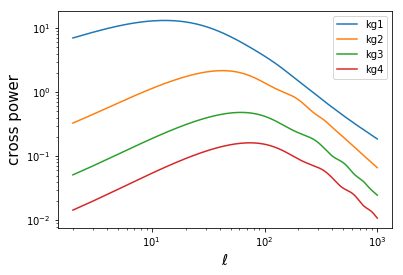

In [37]:
# plot kappa cross galaxy spectra
print Fobj.crossCls.shape
# auto power are on diagonal
print nMaps
labels = ['kk','kg1','kg2','kg3','kg4']
for mapNum in range(1,nMaps):
    plt.loglog(ells,Fobj.crossCls[0,mapNum],label=labels[mapNum])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel('cross power',fontsize=15)
plt.legend()
plt.show()

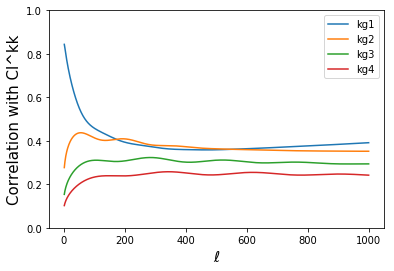

In [38]:
#plot correlation coefficients
labels = ['kk','kg1','kg2','kg3','kg4']
for mapNum in range(1,nMaps):
    Clkg = Fobj.crossCls[0,mapNum]
    Clkk = Fobj.crossCls[0,0]
    Clgg = Fobj.crossCls[mapNum,mapNum]
    r = Clkg/np.sqrt(Clkk*Clgg)
    plt.plot(ells,r,label=labels[mapNum])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel('Correlation with Cl^kk',fontsize=15)
plt.ylim([0,1])
plt.legend()
plt.show()

# Compare normalized and non-normalized cases

In [39]:
# load saved Fobj
# get lensing and galaxy Fisher matrix to add

#import FisherCl2 as fcl
import pickle

# the one with doNorm = False
filehandler2 = open('Fisher_4_4g_Dal.obj', 'r') 
Fobj2 = pickle.load(filehandler2) 
lmax = Fobj2.lmax

# the one with doNorm = True
filehandler3 = open('Fisher_4_4A.obj','r') # first save: lmax=1000, nonlinear=True, ABoost=3, doNorm=True
#filehandler3 = open('Fisher_4_4f_Dal.obj', 'r') 
Fobj3 = pickle.load(filehandler3) 
lmax = Fobj3.lmax


print Fobj2.obsList
print Fobj2.paramList
print Fobj2.lmax

print Fobj3.obsList
print Fobj3.paramList
print Fobj3.lmax



[  0.   1.   2.   3.   4.   6.   7.   8.   9.  12.  13.  14.  18.  19.  24.]
['ombh2', 'omch2', 'cosmomc_theta', 'As', 'ns', 'tau', 'mnu', 'w', 'bin1', 'bin2', 'bin3', 'bin4']
1000
[  0.   1.   2.   3.   4.   6.   7.   8.   9.  12.  13.  14.  18.  19.  24.]
['ombh2', 'omch2', 'cosmomc_theta', 'As', 'ns', 'tau', 'mnu', 'w', 'bin1', 'bin2', 'bin3', 'bin4']
1000


In [40]:
lmin=50
Fij2 = makeFisher(Fobj2,lmin,lmax)
sigmas2 = np.sqrt(np.diag(np.linalg.inv(Fij2)))

lmin=50
Fij3 = makeFisher(Fobj3,lmin,lmax)
sigmas3 = np.sqrt(np.diag(np.linalg.inv(Fij3)))


building Fisher matrix from components...
invCov.shape:  (15, 15, 999) , dClVecs.shape:  (15, 12, 999)
starting bin set  1  of  12
starting bin set  2  of  12
starting bin set  3  of  12
starting bin set  4  of  12
starting bin set  5  of  12
starting bin set  6  of  12
starting bin set  7  of  12
starting bin set  8  of  12
starting bin set  9  of  12
starting bin set  10  of  12
starting bin set  11  of  12
starting bin set  12  of  12
creation of Fisher Matrix complete!

building Fisher matrix from components...
invCov.shape:  (15, 15, 999) , dClVecs.shape:  (15, 12, 999)
starting bin set  1  of  12
starting bin set  2  of  12
starting bin set  3  of  12
starting bin set  4  of  12
starting bin set  5  of  12
starting bin set  6  of  12
starting bin set  7  of  12
starting bin set  8  of  12
starting bin set  9  of  12
starting bin set  10  of  12
starting bin set  11  of  12
starting bin set  12  of  12
creation of Fisher Matrix complete!



In [41]:
paramList = Fobj2.paramList
from prettytable import PrettyTable
t = PrettyTable(['Parameter', 'sigma_NF(k,g)','sigma_NT(k,g)','percent diff.'])
for i,p in enumerate(paramList):
    NF = sigmas2[i]
    NT = sigmas3[i]
    diff = (NF-NT)/NF *100
    t.add_row([p,"%5.3g" % NF,"%5.3g" % NT, "%5.3g" % diff ] )
print t


+---------------+---------------+---------------+---------------+
|   Parameter   | sigma_NF(k,g) | sigma_NT(k,g) | percent diff. |
+---------------+---------------+---------------+---------------+
|     ombh2     |    0.000827   |    0.00029    |      64.9     |
|     omch2     |    0.00192    |    0.00087    |      54.6     |
| cosmomc_theta |    3.39e-05   |    1.93e-05   |      42.9     |
|       As      |     5e-11     |    1.63e-11   |      67.4     |
|       ns      |    0.00663    |    0.00293    |      55.9     |
|      tau      |      5.58     |     0.961     |      82.8     |
|      mnu      |     0.0317    |     0.0156    |      50.8     |
|       w       |     0.0306    |     0.017     |      44.4     |
|      bin1     |     0.0329    |     0.0128    |      61.3     |
|      bin2     |     0.044     |     0.0182    |      58.7     |
|      bin3     |     0.0597    |     0.0243    |      59.2     |
|      bin4     |     0.0759    |     0.0303    |      60.1     |
+---------

In [42]:
# ratio of covariance matrices should leave matrix of powers of normalization factors, and be singular
covRatio = Fobj3.covar/Fobj2.covar
print covRatio.shape
covRatioInv = np.transpose(np.linalg.inv(np.transpose(covRatio)))
print covRatioInv.shape
print Fobj2.ells[0],Fobj2.ells[-1]
print Fobj3.ells[0],Fobj3.ells[-1]

(15, 15, 999)
(15, 15, 999)
2.0 1000.0
2.0 1000.0


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


In [43]:
# check the power spectra for blips or worse
# Fobj3 is the normalized 4,4 one
print Fobj3.crossCls.shape
print Fobj3.crossClsPlus.shape
print Fobj3.crossClsMinus.shape
# example: (3,3,999) means 999 symmetric 3x3 matrices, one at each ell
nMaps = Fobj3.nBins+1
ells = Fobj3.ells
print 'nMaps = ',nMaps
nCosParams = Fobj3.nParams - Fobj3.nBins
print 'nCosParams = ',nCosParams
paramList = Fobj3.paramList
print 'paramList = ',paramList

(5, 5, 999)
(5, 5, 8, 999)
(5, 5, 8, 999)
nMaps =  5
nCosParams =  8
paramList =  ['ombh2', 'omch2', 'cosmomc_theta', 'As', 'ns', 'tau', 'mnu', 'w', 'bin1', 'bin2', 'bin3', 'bin4']


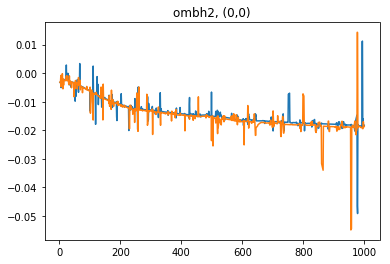

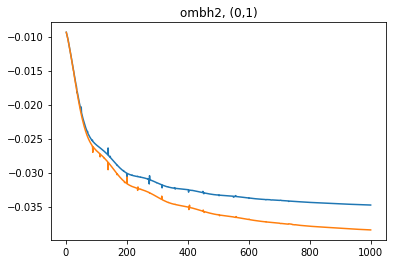

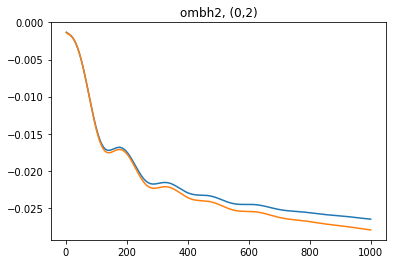

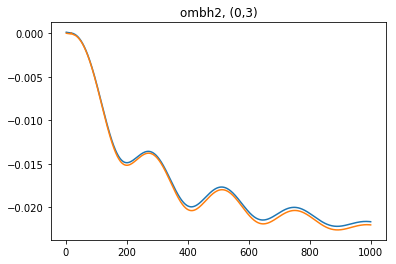

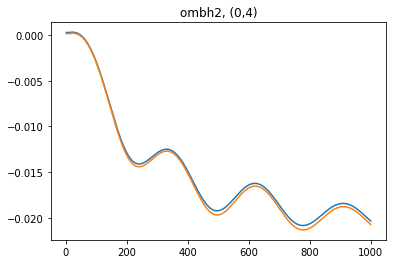

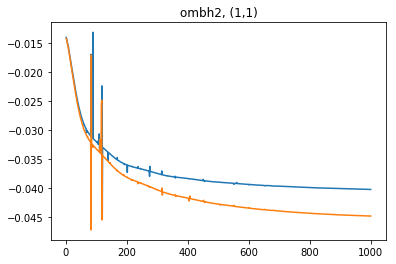

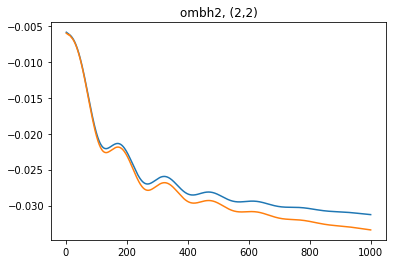

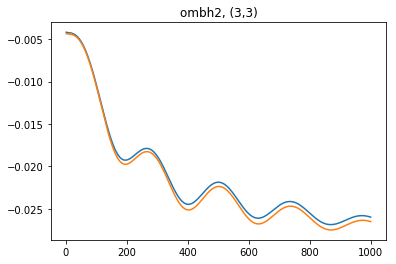

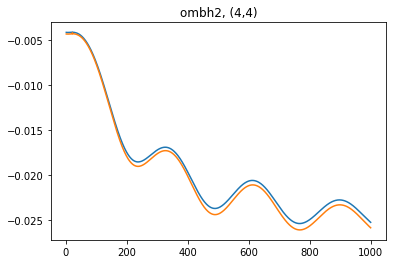

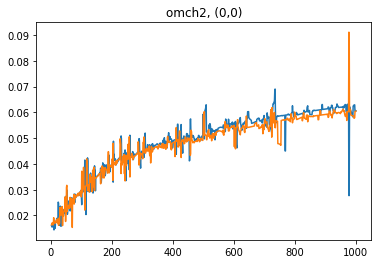

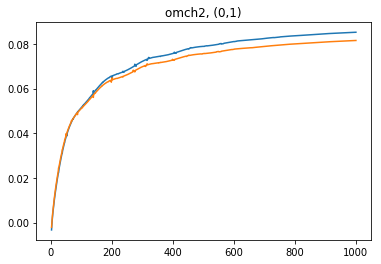

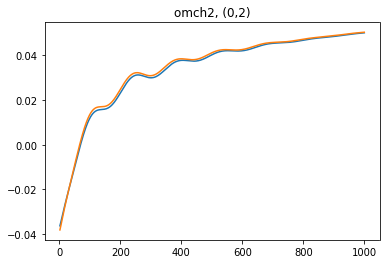

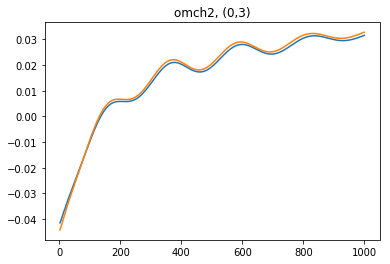

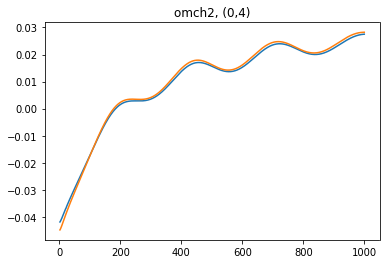

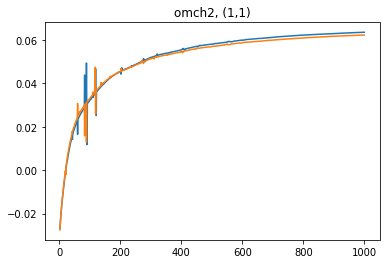

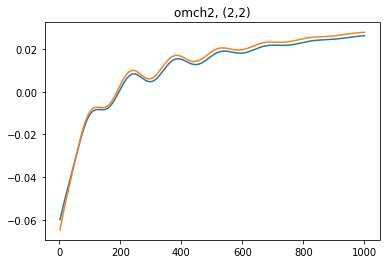

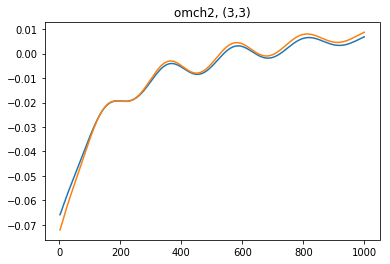

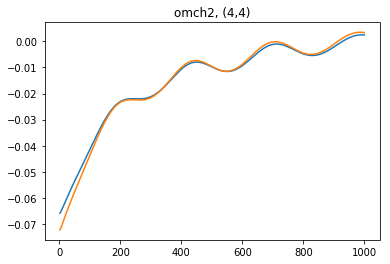

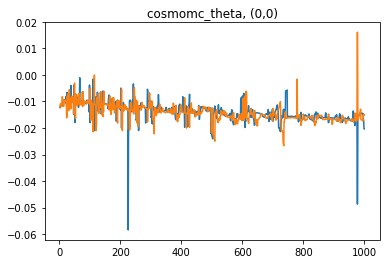

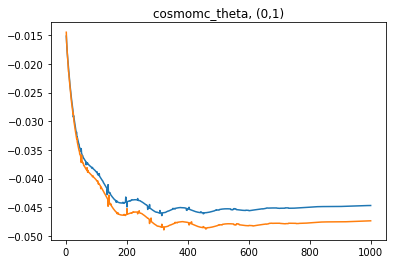

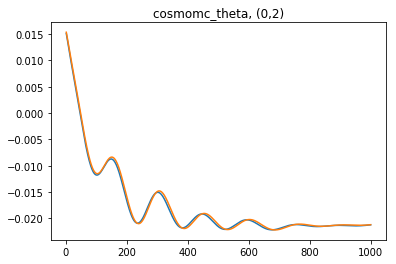

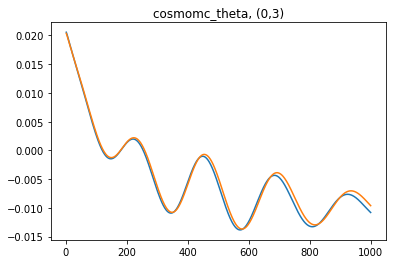

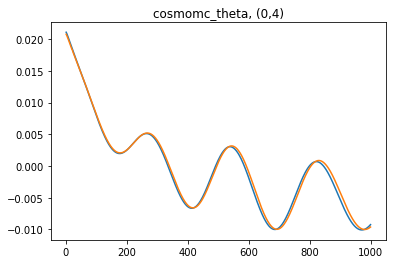

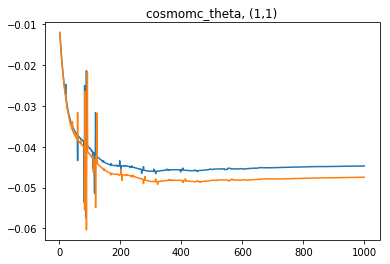

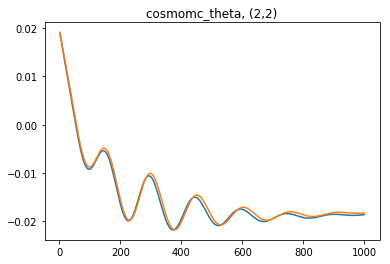

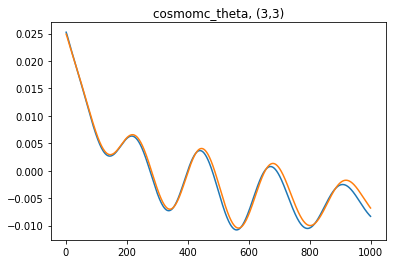

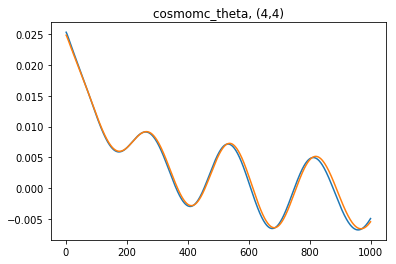

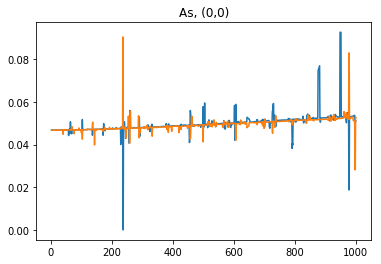

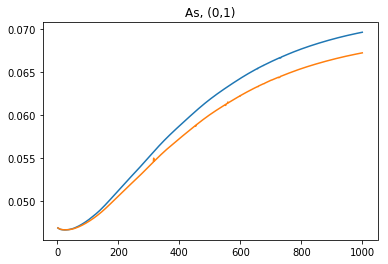

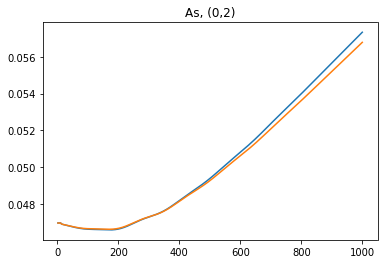

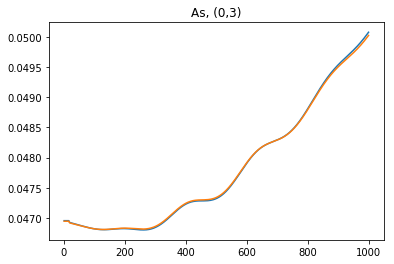

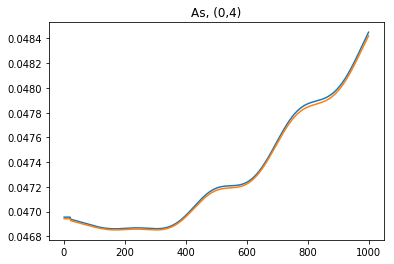

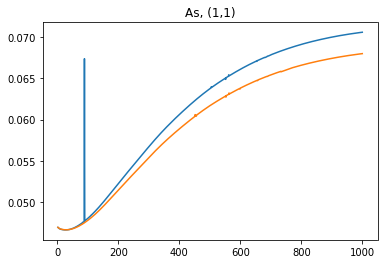

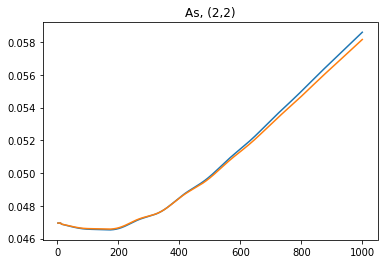

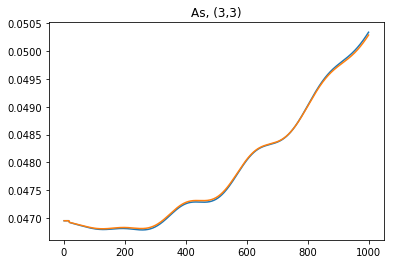

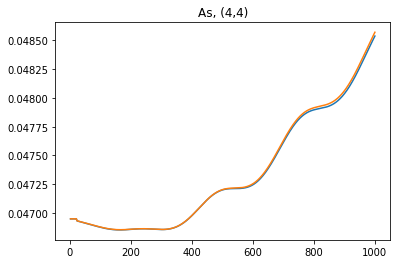

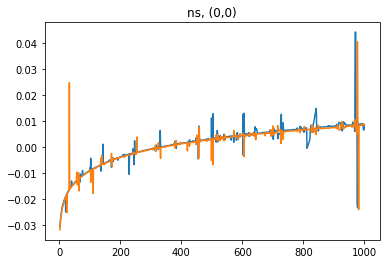

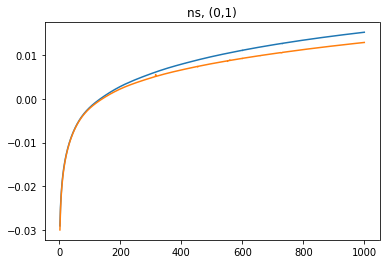

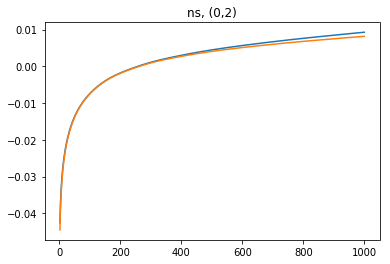

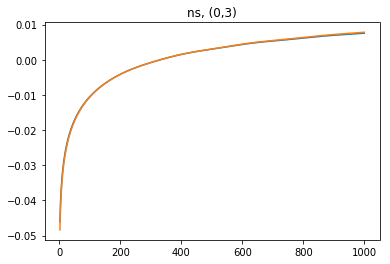

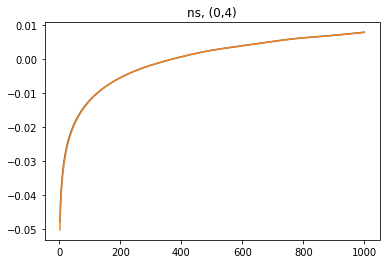

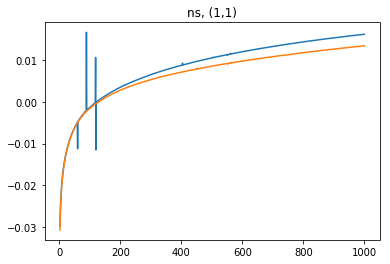

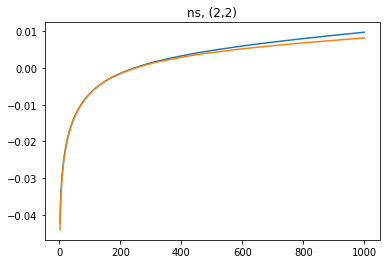

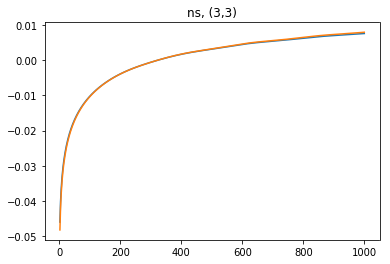

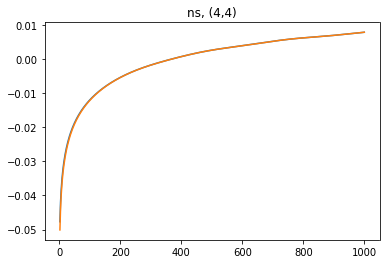

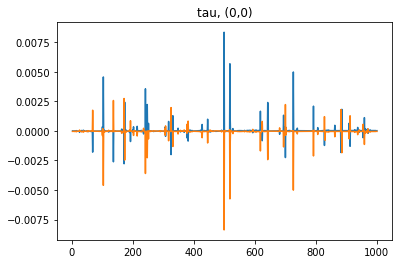

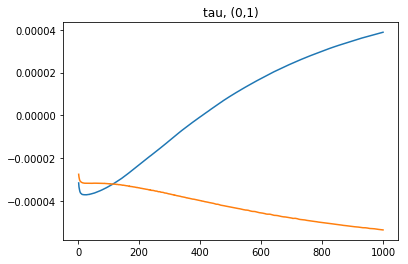

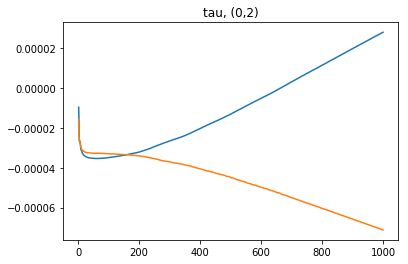

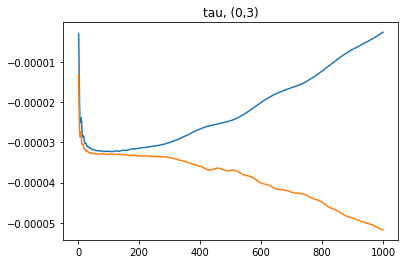

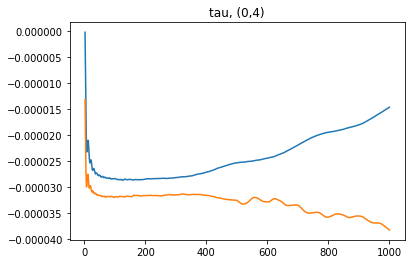

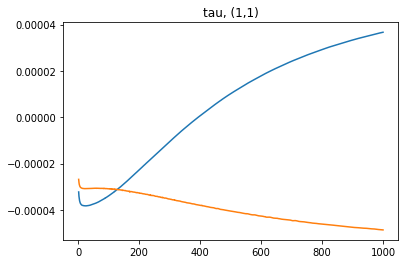

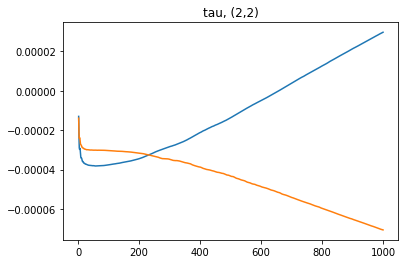

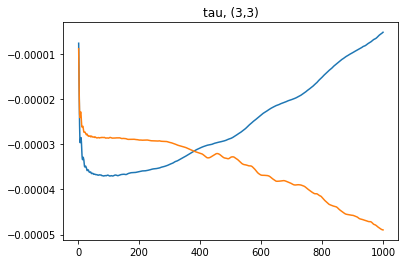

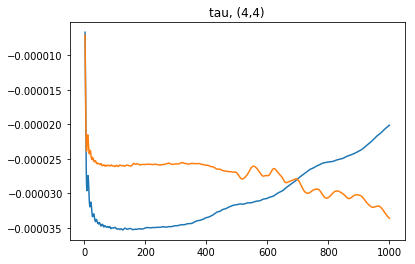

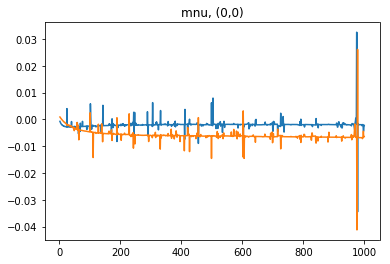

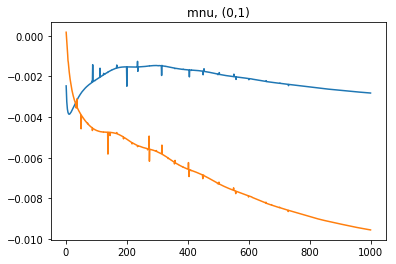

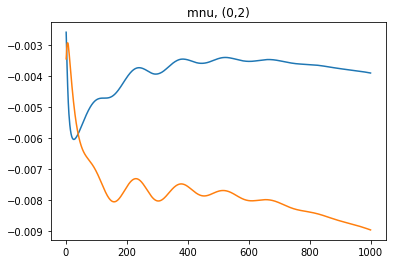

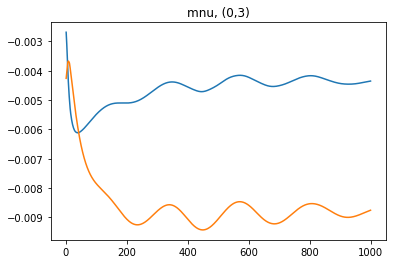

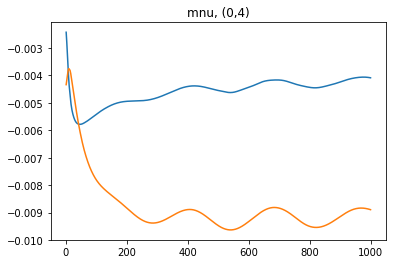

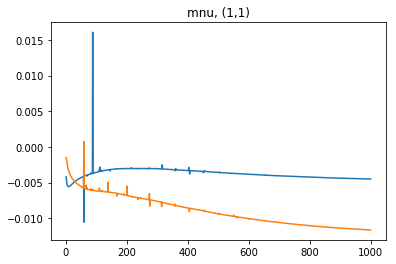

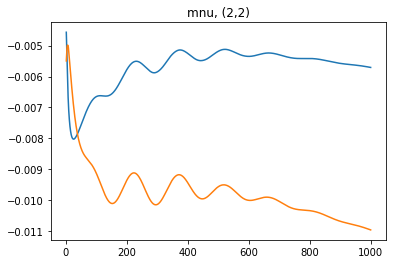

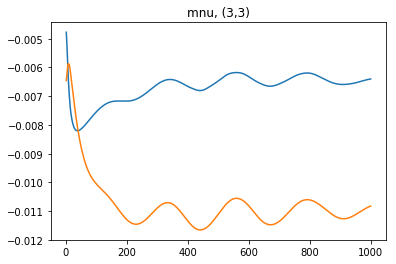

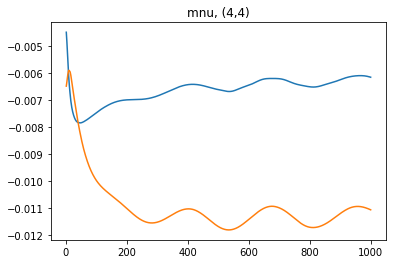

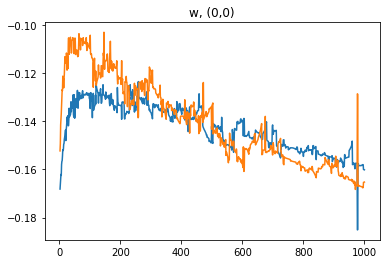

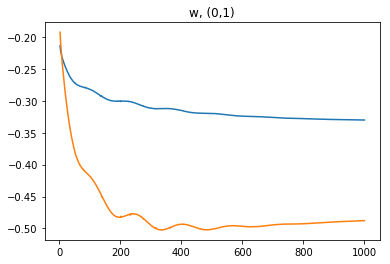

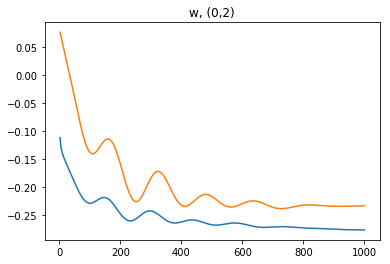

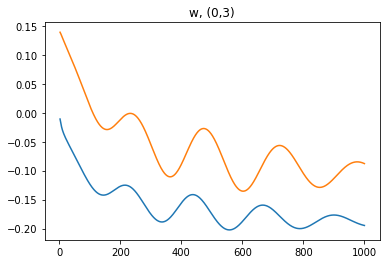

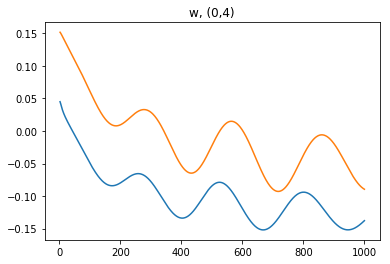

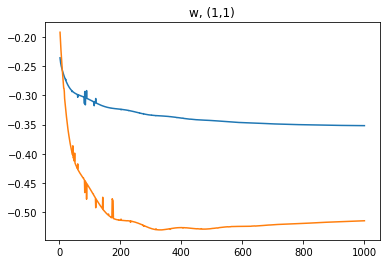

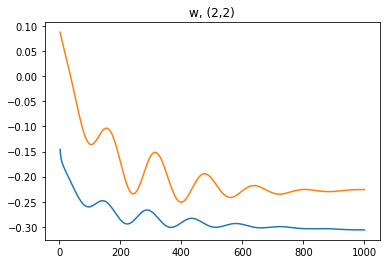

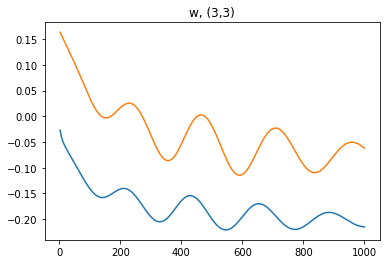

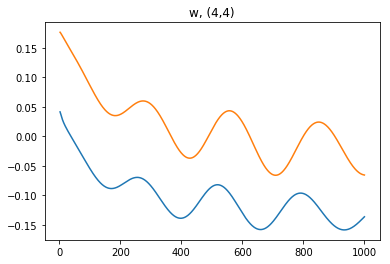

In [44]:
%matplotlib inline
for param in range(nCosParams):        
    for obs1 in range(nMaps):
        for obs2 in range(obs1,nMaps):
            if obs1 == 0 or obs1 == obs2:
                nominal = Fobj3.crossCls[obs1,obs2]
                plus = Fobj3.crossClsPlus[obs1,obs2,param]
                minus = Fobj3.crossClsMinus[obs1,obs2,param]
                plt.plot(ells,(plus-nominal)/nominal)
                plt.plot(ells,(nominal-minus)/nominal)
                plt.title(paramList[param]+', ('+str(obs1)+','+str(obs2)+')')
                plt.show()

In [45]:
# view the derivatives too
#(Obserables(Cls),Parameters,Ells)
print Fobj3.dClVecs.shape
nParams = Fobj3.nParams
print nParams
print nCosParams
nObs = nMaps*(nMaps+1)/2
print nObs

(15, 12, 999)
12
8
15


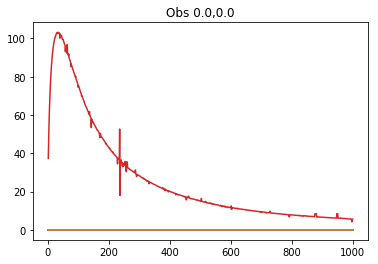

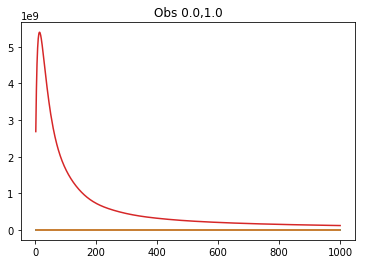

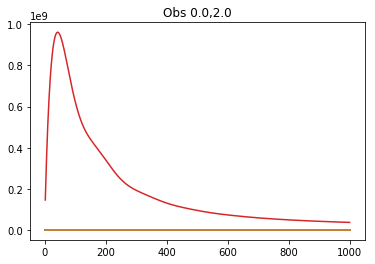

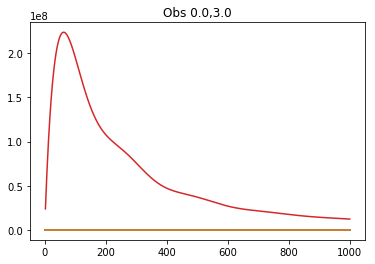

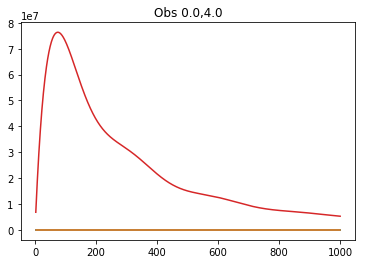

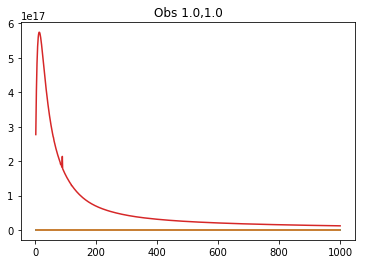

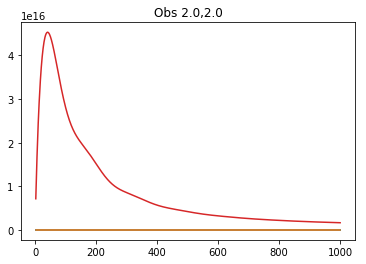

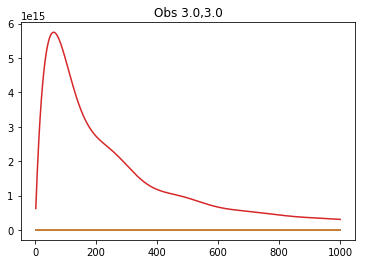

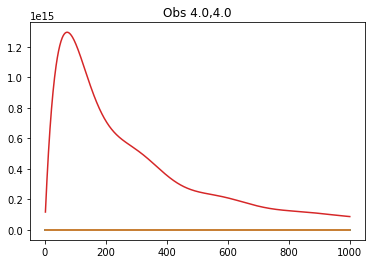

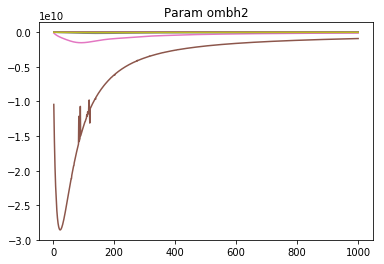

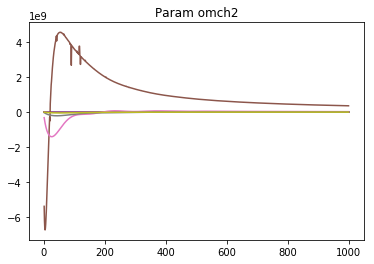

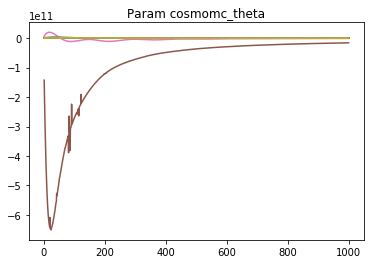

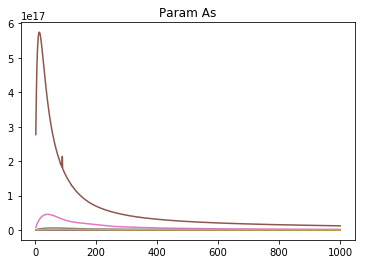

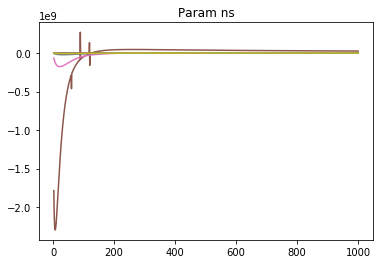

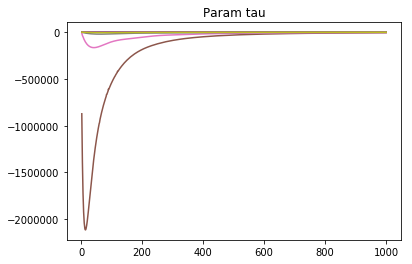

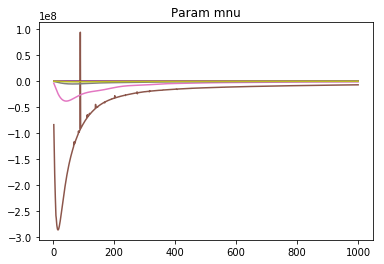

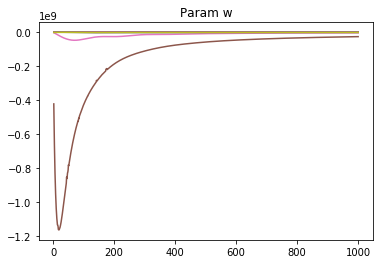

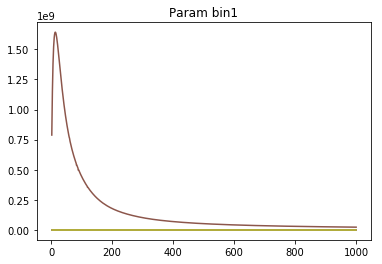

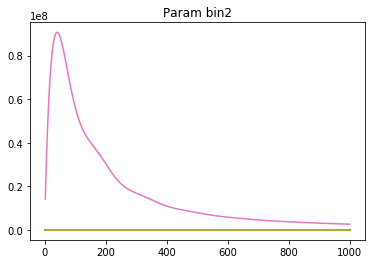

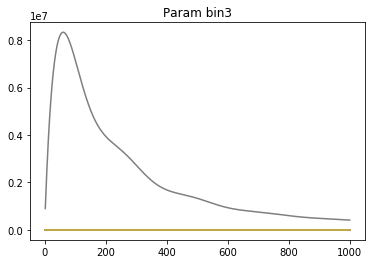

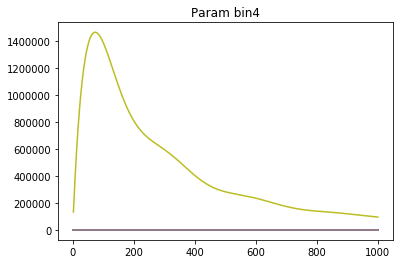

In [46]:
obsList = Fobj3.obsList
map1List = np.floor(obsList/nMaps)
map2List = obsList%nMaps

# plot one panel per observable
for obs in range(nObs):
    if map1List[obs] == 0 or map1List[obs] == map2List[obs]:
        for param in range(nParams):
            plt.plot(ells,Fobj3.dClVecs[obs,param])
        plt.title('Obs '+str(map1List[obs])+','+str(map2List[obs]))
        plt.show()
    
# plot one panel per parameter
for param in range(nParams):
    for obs in range(nObs):
        if map1List[obs] == 0 or map1List[obs] == map2List[obs]:
            plt.plot(ells,Fobj3.dClVecs[obs,param])
    plt.title('Param '+paramList[param])
    plt.show()